In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

In [2]:
nz=281; nx=1361
h=12.5
sig=0.48/(0.5/h)

nsnap=51; nzsnap=329; nxsnap=1409

fpeak=6.4
dt=0.0015
nt=4600

ntr=600

#How good initial model do you want?
siginit=200

In [18]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T
#def read(filename,n=(nx,nz)):
#    return np.fromfile(filename,dtype='float32').reshape((4083,281)).T
def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
    tmp=np.fromfile(filename,dtype='float32').reshape(n).T
    return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/RTM',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}
    

def poynting_dotp_gradp(p,p_prev,p_next):
    dotp=(p_next-p_prev)/(2.*dt)
    dpdz=np.gradient(p,1./h,axis=0)
    dpdx=np.gradient(p,1./h,axis=1)
    return (dotp*dpdz, dotp*dpdx)
    
def poynting_p_dotp_gradp(p,p_prev,p_next):
    tmp=poynting_dotp_gradp(p,p_prev,p_next)
    return (p*tmp[0], p*tmp[1])

def poynting_p_v(p,vz,vx):
    return (p*vz, p*vx)

def gradphi(v,u):
    ph=np.arctan2(v,u)
    dphdz=np.arcsin(np.sin(np.gradient(ph,axis=0)))/h
    dphdx=np.arcsin(np.sin(np.gradient(ph,axis=1)))/h
    return (dphdz,dphdx)

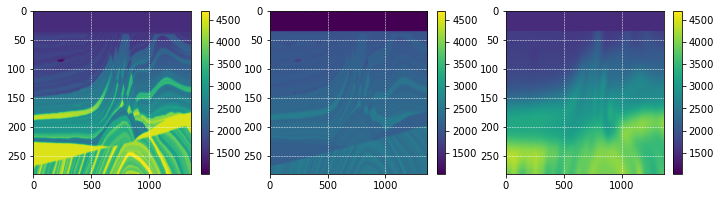

In [4]:
#plot
plt.figure(figsize=(12,3))
true=read('marm',(2*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx-1],clip=[1028,4700])# the first model
plt.subplot(1,3,2); imshow(true[:,nx:],clip=[1028,4700])
plt.subplot(1,3,3); imshow(read('marm_smth'),clip=[1028,4700])

In [9]:
!cat setup_default

MODEL_SIZE              '281 1361 1'
MODEL_SPACING           '12.5 12.5 1'
FILE_MODEL              'marm'
MODEL_ATTRIBUTES         vp
FILE_TOPO               'topo'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '100  1000  0'
DS			'  0   100  0'
NS			1    #144
FR                      '200     0  0'
DR                      '  0    25  0'
NR                      600

SCOMP                   p
RCOMP                   p #'p vz'

NT           4600
DT           0.0015


FPEAK        		6.4
WAVELET_TYPE        'ricker'
T0			0.23
UPDATE_WAVELET		'no'
RDT			0


SNAPSHOT     'p p_prev p_next'
#SNAPSHOT     'p poynz poynx'
#NSNAPSHOT    50


## for RTM ##
FILE_DATA_PREFIX    'results_fwd/dobs_Shot'

JOB           imaging

IF_USE_CHECKPOINT   F


## Observed data

In [14]:
!cp setup_default setup # change the set up name to be the same as the above cell
!echo "DIR_OUT     results_marm_obs" >> setup
!echo "SNAPSHOT     'p vz vx'" >> setup
run(app='../../exe/fwd_AC_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_Imaging_Marmousi
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 702208 Sep 28 15:18 ../../exe/fwd_AC_FDSG_O4_
 Git Commit: 83c8cda
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/28/2023
System time: 15:26:36
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_marm_obs
 Output directory:results_marm_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤

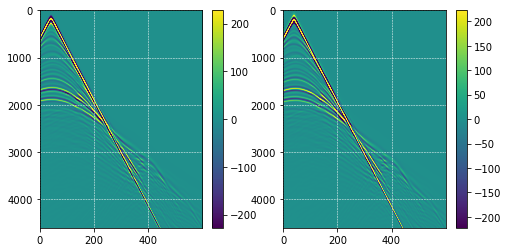

In [11]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_marm_obs/Ru_Shot0001.su'),perc=98)# u is pressure wavefield, Ru = observed data on seismogram
plt.subplot(1,2,2); imshow(read_su('results_marm_obs/Rv_Shot0001.su'),perc=98)#Rv the hilbert transform of Ru 

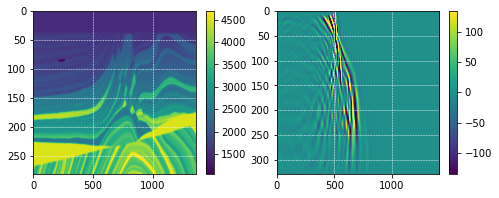

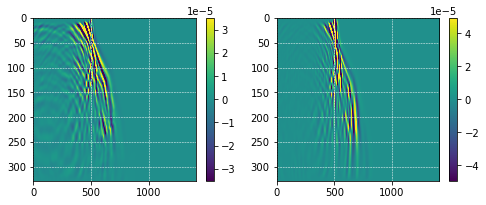

In [12]:
## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(true[:,:nx])

p =read_snap('results_marm_obs/snap_fld_u%p')
vz=read_snap('results_marm_obs/snap_fld_u%vz')
vx=read_snap('results_marm_obs/snap_fld_u%vx')

plt.subplot(1,2,2); imshow(p,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(vz,perc=98)
plt.subplot(1,2,2); imshow(vx,perc=98)

$\vec{s} = \vec{\vec{\sigma}}\cdot\vec{v} = P\vec{v} $

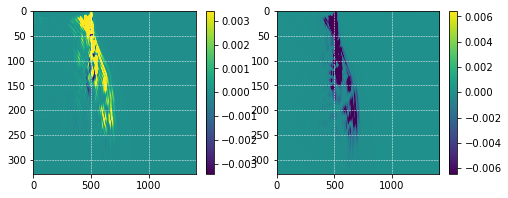

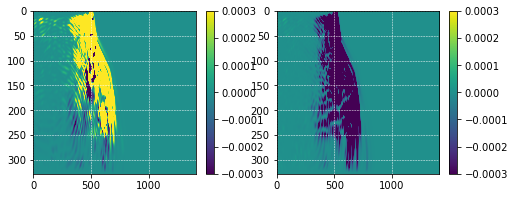

In [19]:
poynz,poynx = poynting_p_v(p,vz,vx)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,clip=[-3e-4,3e-4])
plt.subplot(1,2,2); imshow(poynx,clip=[-3e-4,3e-4])

$\vec{s} = E^2\nabla\phi $

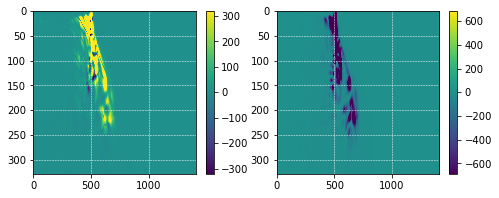

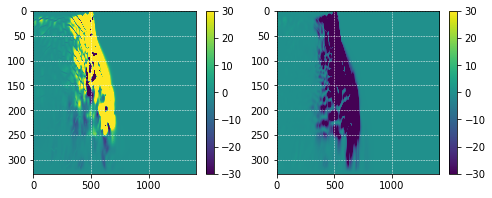

In [17]:
u=read_snap('results_marm_obs/snap_fld_u%p')
v=read_snap('results_marm_obs/snap_fld_v%p')

Esq=u**2+v**2
poynz,poynx =  gradphi(v,u)
poynz=Esq*poynz
poynx=Esq*poynx

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(poynz,clip=[-30,30])
plt.subplot(1,2,2); imshow(poynx,clip=[-30,30])

## Migrating all data

### $\vec{s} = \vec{\vec{\sigma}}\cdot\vec{v} = P\vec{v} $

In [36]:
!cp setup_default setup
!echo "FILE_MODEL   marm_smth" >>setup
!echo "FILE_DATA_PREFIX    'results_obs/Ru_Shot'" >>setup
!echo "SNAPSHOT     'p poynz poynx'" >> setup
!echo "DIR_OUT     results_rtm_Pv" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_Imaging_Marmousi
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 722464 Sep 28 15:49 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 83c8cda
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/28/2023
System time: 16:06:00
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_rtm_Pv
 Output directory:results_rtm_Pv/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.60

 JOB : imaging
 JOB : imaging
 -----------------------
         Imaging        
 -----------------------
 IF_BLOOM is NOT found, take default: T
 IF_BLOOM is NOT found, take default: T
 RTM_ADJSRC is NOT found, take default: dobs
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        4500
 fld_q minmax values:  -25716256.0       31817644.0    
 fld_p minmax values:  -33799040.0       26978356.0    
 fld_v minmax values:  -522.099915       597.721863    
 fld_u minmax values:  -634.290039       438.314850    
 it----        4000
 fld_q minmax values:  -60495432.0       83114928.0    
 fld_p minmax values:  -84390816.0       69197712.0    
 fld_v minmax values:  -578.355530       717.110596    
 fld_u minmax values:  -740.446594       523.372131    
 it----        3500
 fld_q minmax values:  -96585024.0       143762848.    
 fld_p minmax values:  -137196208.       128382208.    
 fld_v minmax values:  -633.398071       861.616638    
 fld_u minmax values:  -849.169434       654.268

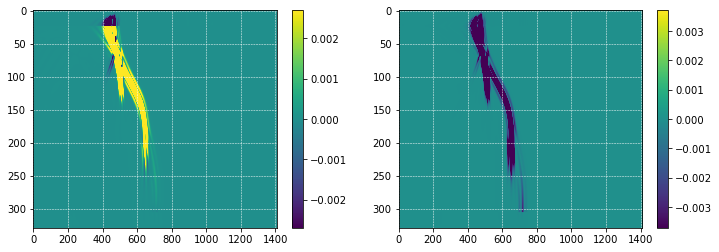

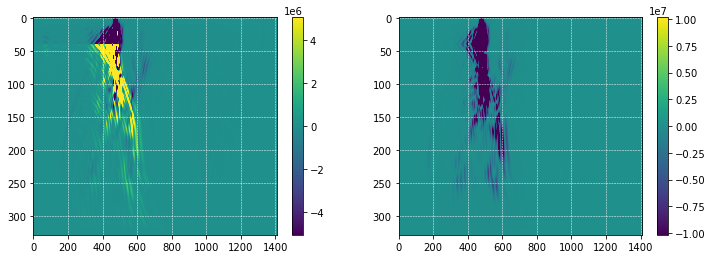

In [37]:
poynz = read_snap('results_rtm_Pv/snap_fld_u%poynz_rev')
poynx = read_snap('results_rtm_Pv/snap_fld_u%poynx_rev')

adj_poynz = read_snap('results_rtm_Pv/snap_fld_p%poynz_rev')
adj_poynx = read_snap('results_rtm_Pv/snap_fld_p%poynx_rev')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(adj_poynz,perc=98)
plt.subplot(1,2,2); imshow(adj_poynx,perc=98)

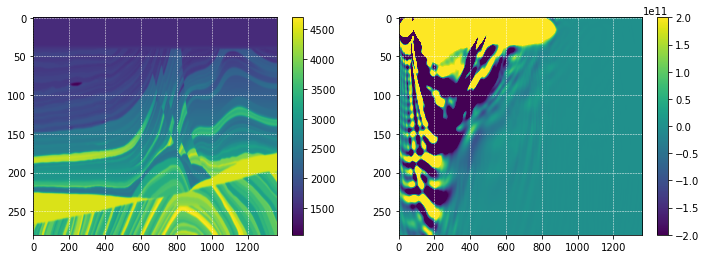

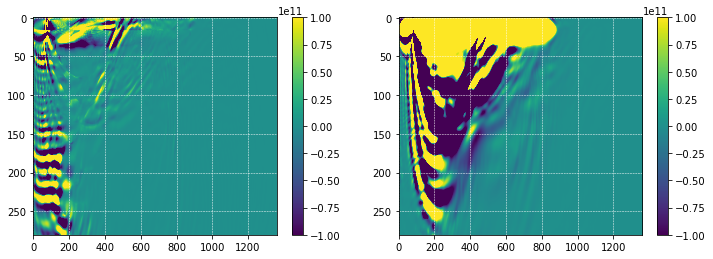

In [34]:
images=read('results_rtm_Pv/correlate_image',n=(3*nx,nz))
ipp=images[:,:nx]
ibksc=images[:,nx:2*nx]
ifwsc=images[:,2*nx:]
del images

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow((true[:,:nx]))
plt.subplot(1,2,2); imshow(ipp,clip=[-2e11,2e11])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(ibksc,clip=[-1e11,1e11]) 
plt.subplot(1,2,2); imshow(ifwsc,clip=[-1e11,1e11])

### $\vec{s} = E^2\nabla\phi $

In [29]:
!cp setup_default setup
!echo "FILE_MODEL   marm_smth" >>setup
!echo "FILE_DATA_PREFIX    'results_obs/Ru_Shot'" >>setup
!echo "POYNTING_DEF    Esq_gradphi" >> setup
!echo "SNAPSHOT     'p poynz poynx'" >> setup
!echo "DIR_OUT     results_rtm_Esqgradphi" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_Imaging_Marmousi
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 722464 Sep 28 15:49 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 83c8cda
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/28/2023
System time: 15:49:34
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_rtm_Esqgradphi
 Output directory:results_rtm_Esqgradphi/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal

 JOB : imaging
 JOB : imaging
 -----------------------
         Imaging        
 -----------------------
 IF_BLOOM is NOT found, take default: T
 IF_BLOOM is NOT found, take default: T
 RTM_ADJSRC is NOT found, take default: dobs
 ----  Solving adjoint eqn & xcorrelate  ----
 it----        4500
 fld_q minmax values:  -25716256.0       31817644.0    
 fld_p minmax values:  -33799040.0       26978356.0    
 fld_v minmax values:  -522.099915       597.721863    
 fld_u minmax values:  -634.290039       438.314850    
 it----        4000
 fld_q minmax values:  -60495432.0       83114928.0    
 fld_p minmax values:  -84390816.0       69197712.0    
 fld_v minmax values:  -578.355530       717.110596    
 fld_u minmax values:  -740.446594       523.372131    
 it----        3500
 fld_q minmax values:  -96585024.0       143762848.    
 fld_p minmax values:  -137196208.       128382208.    
 fld_v minmax values:  -633.398071       861.616638    
 fld_u minmax values:  -849.169434       654.268

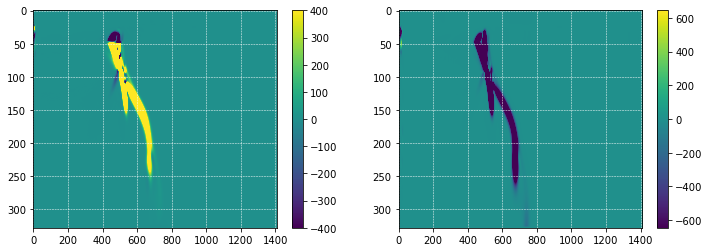

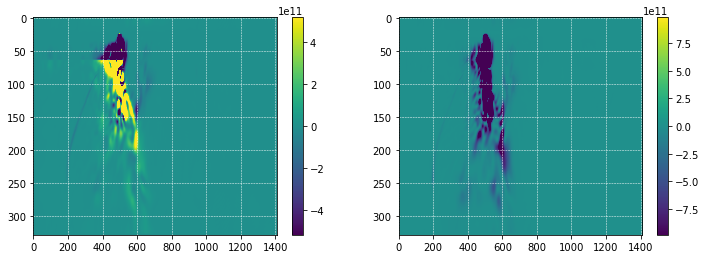

In [38]:
poynz = read_snap('results_rtm_Esqgradphi/snap_fld_u%poynz_rev')
poynx = read_snap('results_rtm_Esqgradphi/snap_fld_u%poynx_rev')

adj_poynz = read_snap('results_rtm_Esqgradphi/snap_fld_p%poynz_rev')
adj_poynx = read_snap('results_rtm_Esqgradphi/snap_fld_p%poynx_rev')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(poynz,perc=98)
plt.subplot(1,2,2); imshow(poynx,perc=98)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(adj_poynz,perc=98)
plt.subplot(1,2,2); imshow(adj_poynx,perc=98)

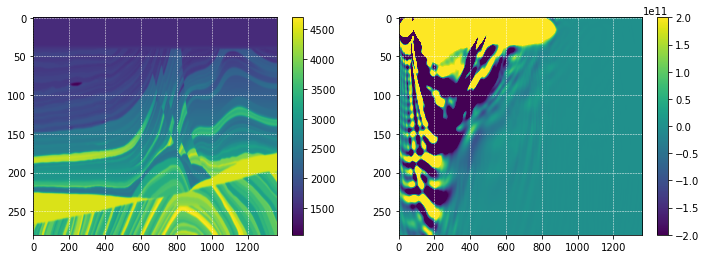

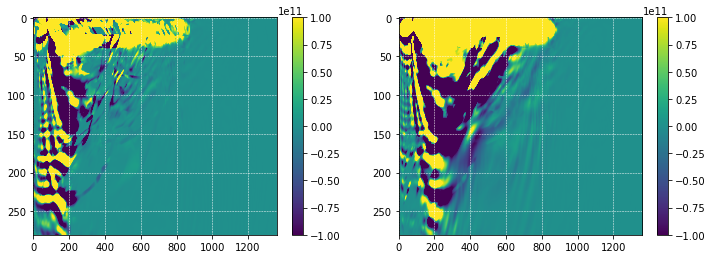

In [35]:
images=read('results_rtm_Esqgradphi/correlate_image',n=(3*nx,nz))
ipp=images[:,:nx]
ibksc=images[:,nx:2*nx]
ifwsc=images[:,2*nx:]
del images

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow((true[:,:nx]))
plt.subplot(1,2,2); imshow(ipp,clip=[-2e11,2e11])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); imshow(ibksc,clip=[-1e11,1e11]) 
plt.subplot(1,2,2); imshow(ifwsc,clip=[-1e11,1e11])